In [1]:
%matplotlib inline
import pymc3 as pm
import numpy as np
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use(['seaborn-colorblind', 'seaborn-darkgrid'])
np.set_printoptions(precision=2)

# Simple example

In [2]:
clusters = 3

n_cluster = [90, 50, 75]
n_total = sum(n_cluster)

means = [9, 21, 35]
std_devs = [2, 2, 2]

mix = np.random.normal(np.repeat(means, n_cluster), np.repeat(std_devs, n_cluster))

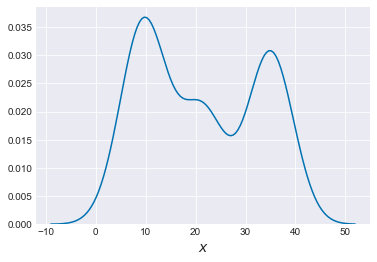

In [3]:
sns.kdeplot(np.array(mix))
plt.xlabel('$x$', fontsize=14)
plt.savefig('B04958_07_01.png', dpi=300, figsize=[5.5, 5.5])

In [4]:
# Author: Thomas Boggs

import matplotlib.tri as tri
from functools import reduce
from matplotlib import ticker, cm

_corners = np.array([[0, 0], [1, 0], [0.5, 0.75**0.5]])
_triangle = tri.Triangulation(_corners[:, 0], _corners[:, 1])
_midpoints = [(_corners[(i + 1) % 3] + _corners[(i + 2) % 3]) / 2.0 for i in range(3)]

def xy2bc(xy, tol=1.e-3):
    '''Converts 2D Cartesian coordinates to barycentric.
    Arguments:
        xy: A length-2 sequence containing the x and y value.
    '''
    s = [(_corners[i] - _midpoints[i]).dot(xy - _midpoints[i]) / 0.75 for i in range(3)]
    return np.clip(s, tol, 1.0 - tol)

class Dirichlet(object):
    def __init__(self, alpha):
        '''Creates Dirichlet distribution with parameter `alpha`.'''
        from math import gamma
        from operator import mul
        self._alpha = np.array(alpha)
        self._coef = gamma(np.sum(self._alpha)) /reduce(mul, [gamma(a) for a in self._alpha])
    def pdf(self, x):
        '''Returns pdf value for `x`.'''
        from operator import mul
        return self._coef * reduce(mul, [xx ** (aa - 1)
                                         for (xx, aa)in zip(x, self._alpha)])
    def sample(self, N):
        '''Generates a random sample of size `N`.'''
        return np.random.dirichlet(self._alpha, N)

def draw_pdf_contours(dist, nlevels=100, subdiv=8, **kwargs):
    '''Draws pdf contours over an equilateral triangle (2-simplex).
    Arguments:
        dist: A distribution instance with a `pdf` method.
        border (bool): If True, the simplex border is drawn.
        nlevels (int): Number of contours to draw.
        subdiv (int): Number of recursive mesh subdivisions to create.
        kwargs: Keyword args passed on to `plt.triplot`.
    '''
    refiner = tri.UniformTriRefiner(_triangle)
    trimesh = refiner.refine_triangulation(subdiv=subdiv)
    pvals = [dist.pdf(xy2bc(xy)) for xy in zip(trimesh.x, trimesh.y)]

    plt.tricontourf(trimesh, pvals, nlevels, cmap=cm.Blues, **kwargs)
    plt.axis('equal')
    plt.xlim(0, 1)
    plt.ylim(0, 0.75**0.5)
    plt.axis('off')

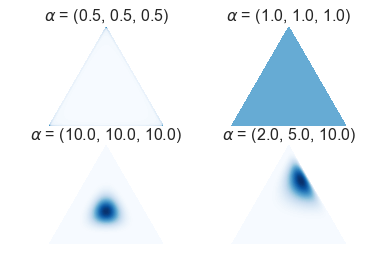

In [5]:
alphas = [[0.5] * 3, [1] * 3, [10] * 3, [2, 5, 10]]
for (i, alpha) in enumerate(alphas):
    plt.subplot(2, 2, i + 1)
    dist = Dirichlet(alpha)
    draw_pdf_contours(dist)
    plt.title(r'$\alpha$ = ({:.1f}, {:.1f}, {:.1f})'.format(*alpha), fontsize=16)
    
plt.savefig('B04958_07_02.png', dpi=300, figsize=[5.5, 5.5])

In [6]:
with pm.Model() as model_kg:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # Known Gaussians means
    means = pm.math.constant([10, 20, 35])

    y = pm.Normal('y', mu=means[category], sd=2, observed=mix)

    trace_kg = pm.sample(1000)

Assigned NUTS to p_stickbreaking__
Assigned CategoricalGibbsMetropolis to category
100%|██████████| 1500/1500 [01:26<00:00, 17.29it/s]


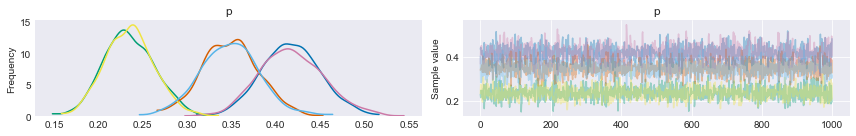

In [7]:
varnames_kg = ['p']
pm.traceplot(trace_kg, varnames_kg)
plt.savefig('B04958_07_03.png', dpi=300, figsize=[5.5, 5.5])

In [8]:
pm.summary(trace_kg, varnames_kg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
p__0,0.417007,0.034810,0.000733,0.352532,0.487576,2000.0,0.999585
p__1,0.234733,0.028056,0.000593,0.183616,0.290475,2000.0,0.999544
p__2,0.348260,0.032687,0.000692,0.277053,0.406507,2000.0,0.999742


In [9]:
#krusckeplot

In [10]:
with pm.Model() as model_ug:
    # Each observation is assigned to a cluster/component with probability p
    p = pm.Dirichlet('p', a=np.ones(clusters))
    category = pm.Categorical('category', p=p, shape=n_total) 
    
    # We estimate the unknown gaussians means and standard deviation
    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)

    y = pm.Normal('y', mu=means[category], sd=sd, observed=mix)

    trace_ug = pm.sample(1000)

Assigned NUTS to p_stickbreaking__
Assigned CategoricalGibbsMetropolis to category
Assigned NUTS to means
Assigned NUTS to sd_log__
100%|██████████| 1500/1500 [02:17<00:00, 10.88it/s]

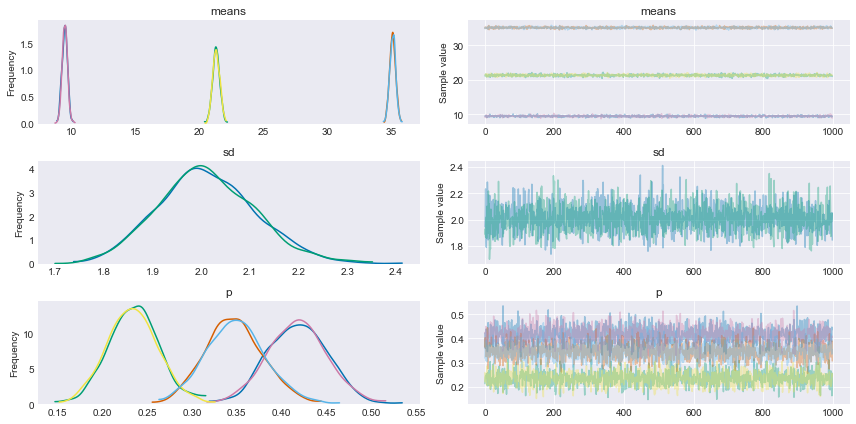

In [11]:
varnames_ug = ['means', 'sd', 'p']
pm.traceplot(trace_ug, varnames_ug)
plt.savefig('B04958_07_05.png', dpi=300, figsize=[5.5, 5.5])

In [12]:
pm.summary(trace_ug, varnames_ug)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
means__0,9.458283,0.211089,0.003803,9.058919,9.876593,2000.0,0.999693
means__1,21.293322,0.278293,0.006233,20.753426,21.830239,2000.0,0.999554
means__2,35.091361,0.231137,0.004892,34.616512,35.518914,2000.0,0.999536
sd,2.010988,0.099604,0.002070,1.834821,2.224087,2000.0,0.999500
p__0,0.417163,0.033351,0.000685,0.352868,0.482704,2000.0,0.999619
p__1,0.234740,0.028579,0.000590,0.177359,0.290803,2000.0,1.000212
p__2,0.348097,0.032678,0.000661,0.283647,0.411487,2000.0,1.000688


In [13]:
ppc = pm.sample_ppc(trace_ug, 50, model_ug)

  0%|          | 0/50 [00:00<?, ?it/s]


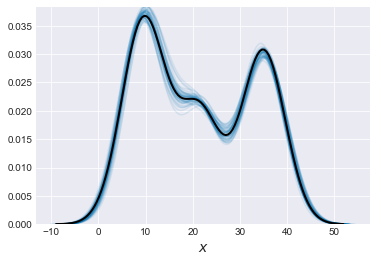

In [37]:
for i in ppc['y']:
    sns.kdeplot(i, alpha=0.1, color='C0')

sns.kdeplot(np.array(mix), lw=2, color='k') # you may want to replace this with the posterior mean
plt.xlabel('$x$', fontsize=14)

plt.savefig('B04958_07_06.png', dpi=300, figsize=[5.5, 5.5])

## Marginalized Gaussian Mixture model

In [15]:
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(clusters))

    means = pm.Normal('means', mu=[10, 20, 35], sd=2, shape=clusters)
    sd = pm.HalfCauchy('sd', 5)
    
    y = pm.NormalMixture('y', w=p, mu=means, sd=sd, observed=mix)

    trace_mg = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:20<00:00, 267.51it/s]


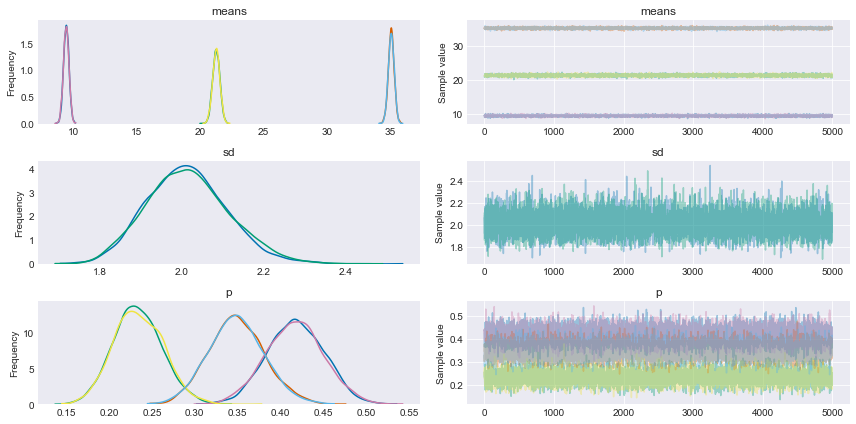

In [16]:
chain_mg = trace_mg[:]
varnames_mg = ['means', 'sd', 'p']
pm.traceplot(chain_mg, varnames_mg);

## Zero inflated Poisson model

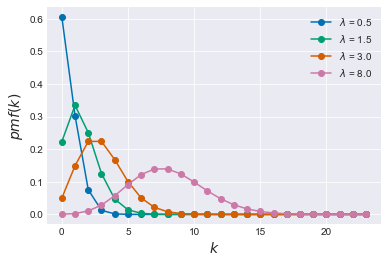

In [17]:
lam_params = [0.5, 1.5, 3, 8]
k = np.arange(0, max(lam_params) * 3)
for lam in lam_params:
    y = stats.poisson(lam).pmf(k)
    plt.plot(k, y, 'o-', label="$\\lambda$ = {:3.1f}".format(lam))
plt.legend()
plt.xlabel('$k$', fontsize=14)
plt.ylabel('$pmf(k)$', fontsize=14)
plt.savefig('B04958_07_07.png', dpi=300, figsize=(5.5, 5.5))

In [18]:
np.random.seed(42)
n = 100
theta = 2.5  # Poisson rate
pi = 0.1  # probability of extra-zeros (pi = 1-psi)

# Simulate some data
counts = np.array([(np.random.random() > pi) * np.random.poisson(theta) for i in range(n)])

In [19]:
#plt.hist(counts, bins=30);

In [20]:
with pm.Model() as ZIP:
    psi = pm.Beta('psi', 1, 1)
    lam = pm.Gamma('lam', 2, 0.1)
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=counts)
    trace_ZIP = pm.sample(5000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|██████████| 5500/5500 [00:07<00:00, 700.53it/s]


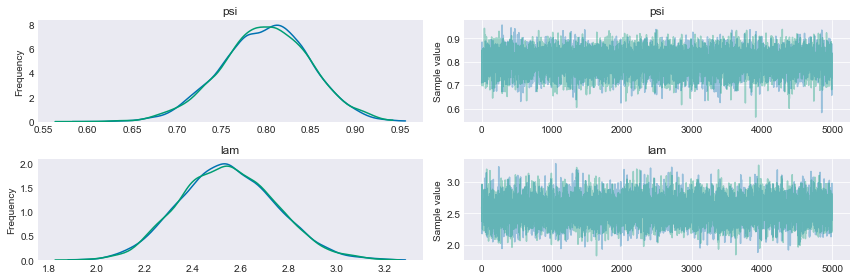

In [21]:
pm.traceplot(trace_ZIP);
plt.savefig('B04958_07_08.png', dpi=300, figsize=(5.5, 5.5))

In [22]:
pm.summary(trace_ZIP)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
psi,0.799326,0.049420,0.000538,0.700454,0.894999,8266.0,0.999901
lam,2.545952,0.199378,0.002192,2.161913,2.933934,8605.0,0.999979


## Zero inflated Poisson regression

In [23]:
#Kruschke plot

In [24]:
fish_data = pd.read_csv('fish.csv')
fish_data.head()

,nofish,livebait,camper,persons,child,xb,zg,count
0,1,0,0,1,0,-0.896315,3.050405,0
1,0,1,1,1,0,-0.558345,1.746149,0
2,0,1,0,1,0,-0.401731,0.279939,0
3,0,1,1,2,1,-0.956298,-0.601526,0
4,0,1,0,1,0,0.436891,0.527709,1


In [25]:
#plt.hist(fish_data['count'], bins=20);

In [26]:
with pm.Model() as ZIP_reg:
    psi = pm.Beta('psi', 1, 1)
    
    alpha = pm.Normal('alpha', 0, 10)
    beta = pm.Normal('beta', 0, 10, shape=2)
    lam = pm.math.exp(alpha + beta[0] * fish_data['child'] + beta[1] * fish_data['camper'])
    
    y = pm.ZeroInflatedPoisson('y', psi, lam, observed=fish_data['count'])
    trace_ZIP_reg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
 97%|█████████▋| 2428/2500 [00:12<00:00, 161.24it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:452: UserWarning: The acceptance probability in chain 1 does not match the target. It is 0.882502918312, but should be close to 0.8. Try to increase the number of tuning steps.
  % (self._chain_id, mean_accept, target_accept))
100%|██████████| 2500/2500 [00:13<00:00, 186.54it/s]


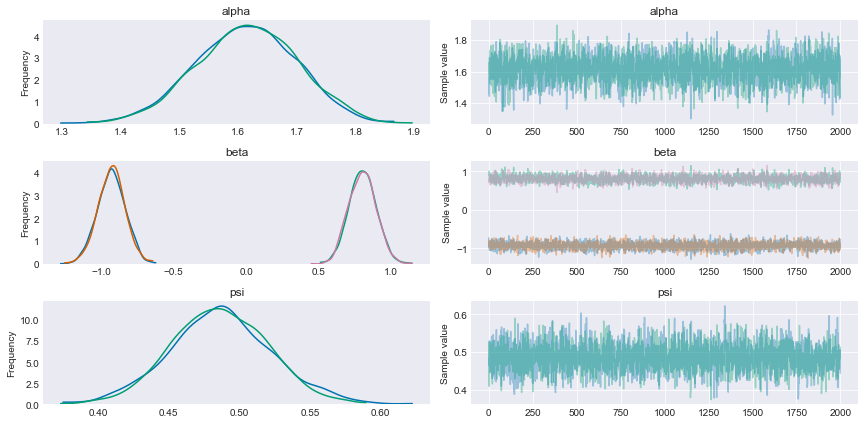

In [27]:
pm.traceplot(trace_ZIP_reg)
plt.savefig('B04958_07_10.png', dpi=300, figsize=(5.5, 5.5));

In [28]:
pm.summary(trace_ZIP_reg)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,1.614027,0.085248,0.001735,1.452834,1.784128,1881.0,1.000094
beta__0,-0.930158,0.094788,0.001705,-1.108784,-0.734746,2748.0,0.999761
beta__1,0.804208,0.093220,0.002010,0.616007,0.974180,1889.0,0.999952
psi,0.486121,0.035100,0.000687,0.421657,0.561386,2453.0,1.000044


In [29]:
children =  [0, 1, 2, 3, 4]
fish_count_pred_0 = []
fish_count_pred_1 = []
thin = 5
for n in children:
    without_camper = trace_ZIP_reg['alpha'][::thin] + trace_ZIP_reg['beta'][:,0][::thin] * n
    with_camper = without_camper + trace_ZIP_reg['beta'][:,1][::thin]
    fish_count_pred_0.append(np.exp(without_camper))
    fish_count_pred_1.append(np.exp(with_camper))

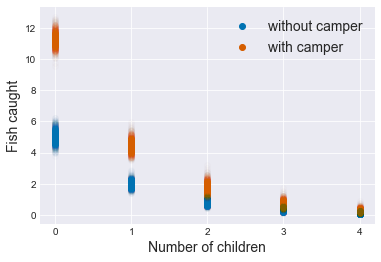

In [30]:
plt.plot(children, fish_count_pred_0, 'C0o', alpha=0.01)
plt.plot(children, fish_count_pred_1, 'C2o', alpha=0.01)

plt.xticks(children);
plt.xlabel('Number of children', fontsize=14)
plt.ylabel('Fish caught', fontsize=14)
plt.plot([], 'C0o', label='without camper')
plt.plot([], 'C2o', label='with camper')
plt.legend(fontsize=14)
plt.savefig('B04958_07_11.png', dpi=300, figsize=(5.5, 5.5))

## Robust logistic Regression

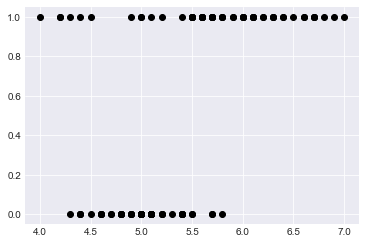

In [31]:
iris = sns.load_dataset("iris")
df = iris.query("species == ('setosa', 'versicolor')")
y_0 = pd.Categorical(df['species']).codes
x_n = 'sepal_length' 
x_0 = df[x_n].values
y_0 = np.concatenate((y_0, np.ones(6)))
x_0 = np.concatenate((x_0, [4.2, 4.5, 4.0, 4.3, 4.2, 4.4]))
x_0_m = x_0 - x_0.mean()
plt.plot(x_0, y_0, 'o', color='k')
plt.savefig('B04958_07_12.png', dpi=300, figsize=(5.5, 5.5))

In [32]:
with pm.Model() as model_rlg:
    alpha_tmp = pm.Normal('alpha_tmp', mu=0, sd=100)
    beta = pm.Normal('beta', mu=0, sd=10)
    
    mu = alpha_tmp + beta * x_0_m
    theta = pm.Deterministic('theta', 1 / (1 + pm.math.exp(-mu)))
    
    pi = pm.Beta('pi', 1, 1)
    p = pi * 0.5 + (1 - pi) * theta
    
    alpha = pm.Deterministic('alpha', alpha_tmp - beta * x_0.mean())
    bd = pm.Deterministic('bd', -alpha/beta)
    
    yl = pm.Bernoulli('yl', p=p, observed=y_0)
    
    trace_rlg = pm.sample(2000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
100%|█████████▉| 2495/2500 [00:06<00:00, 444.75it/s]/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 0 contains 17 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))
100%|██████████| 2500/2500 [00:06<00:00, 412.57it/s]
/home/osvaldo/Documentos/Proyectos/01_PyMC3/pymc3/pymc3/step_methods/hmc/nuts.py:468: UserWarning: Chain 1 contains 7 diverging samples after tuning. If increasing `target_accept` does not help try to reparameterize.
  % (self._chain_id, n_diverging))


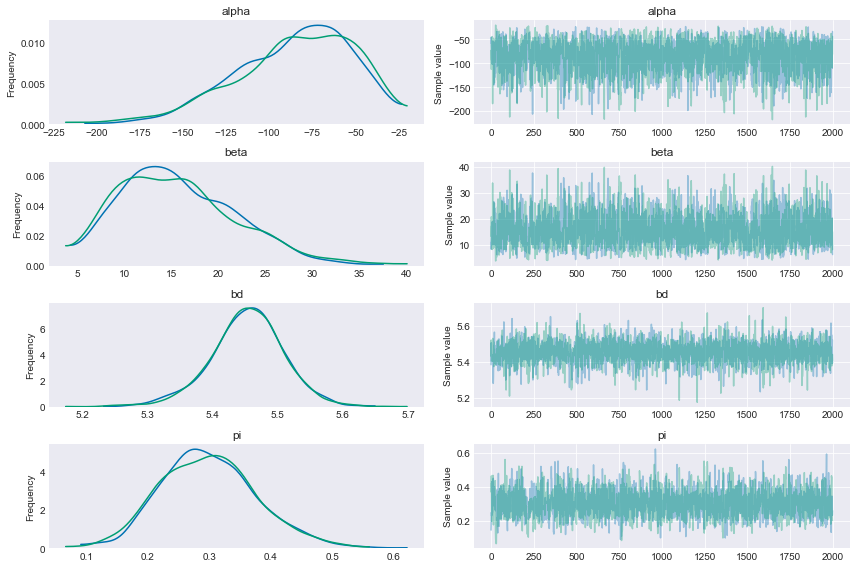

In [33]:
varnames = ['alpha', 'beta', 'bd', 'pi']
pm.traceplot(trace_rlg, varnames)
plt.savefig('B04958_07_13.png', dpi=300, figsize=(5.5, 5.5))

In [34]:
pm.summary(trace_rlg, varnames)

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
alpha,-85.995967,34.121311,0.745830,-151.662813,-28.471670,1883.0,0.999936
beta,15.767439,6.244457,0.136015,5.056595,27.573068,1894.0,0.999928
bd,5.452594,0.057166,0.001015,5.335302,5.564809,3124.0,0.999891
pi,0.299496,0.078036,0.001539,0.161533,0.467671,1814.0,1.000072


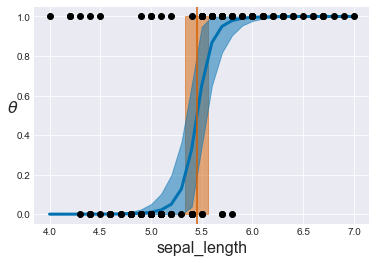

In [35]:
theta = trace_rlg['theta'].mean(axis=0)
idx = np.argsort(x_0)
plt.plot(x_0[idx], theta[idx], color='C0', lw=3);
plt.axvline(trace_rlg['bd'].mean(), ymax=1, color='C2')
bd_hpd = pm.hpd(trace_rlg['bd'])
plt.fill_betweenx([0, 1], bd_hpd[0], bd_hpd[1], color='C2', alpha=0.5)

plt.plot(x_0, y_0, 'o', color='k')
theta_hpd = pm.hpd(trace_rlg['theta'])[idx]
plt.fill_between(x_0[idx], theta_hpd[:,0], theta_hpd[:,1], color='C0', alpha=0.5)

plt.xlabel(x_n, fontsize=16)
plt.ylabel('$\\theta$', rotation=0, fontsize=16)
plt.savefig('B04958_07_14.png', dpi=300, figsize=(5.5, 5.5))

In [36]:
import sys, IPython, scipy, matplotlib, platform
print("This notebook was created on a %s computer running %s and using:\nPython %s\nIPython %s\nPyMC3 %s\nNumPy %s\nSciPy %s\nMatplotlib %s\nSeaborn %s\nPandas %s" % (platform.machine(), ' '.join(platform.linux_distribution()[:2]), sys.version[:5], IPython.__version__, pm.__version__, np.__version__, scipy.__version__, matplotlib.__version__, sns.__version__, pd.__version__))

This notebook was created on a x86_64 computer running debian stretch/sid and using:
Python 3.6.2
IPython 6.1.0
PyMC3 3.2
NumPy 1.13.3
SciPy 1.0.0
Matplotlib 2.1.0
Seaborn 0.8.0
Pandas 0.20.3
